In [274]:
#Question: How does changing the SRC Eigenmode ONLY effect the QM-limited Sensitivity?
#Question: How does changing the lensing of the beam coming from SRC effect the QM-limited Sensitivity?
####

In [275]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
from pykat.tools import modematching
import pylab as pl
import pandas
import matplotlib.pyplot as plt
import matplotlib
import csv
import math
import numpy as np

### My functions
from kat_commands import *
from MMT import modematch
from cav_commands import *
from load_kat_data import *
import get_WS
import trace_mode

In [302]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat"
maxtem = 6

In [303]:
#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.load(katfile)
basekat.parse(darm_commands)
basekat.parse(add_squeezing)
basekat.parse(cav_commands_FC_first)
basekat.parse("maxtem "+str(maxtem))
basekat.parse("""
bp q_sqz_x x q nsqz
bp q_sqz_y y q nsqz
bp q_OM1_x x q nOM1a
bp q_OM1_y y q nOM1a

bp SRCoutx x q nIBAin
bp SRCouty y q nIBAin

bp SRMYqx x q nSRMHRa
bp SRMYqy y q nSRMHRa

bp ITMXqx x q nITMX2
bp ITMXqy y q nITMX2

bp ITMYqx x q nITMY2
bp ITMYqy y q nITMY2

bp OMCqx x q nOMC_HROC_refl
bp OMCqy y q nOMC_HROC_refl

bp OFIqx x q nIBAin
bp OFIqy y q nIBAin

qnoised PDquantumnoise 1 $fs nOMC_AROC_trans
qshot PDshotnoise 1 $fs nOMC_AROC_trans
pd1 signal $fs nOMC_AROC_trans
""")

basekat.undumpify() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out_perfect_mm = kat.run()

In [304]:
SRCTL_q_perfect_x = out_perfect_mm["SRCoutx"] #q's coming out of the SRC @ the OFI
SRCTL_q_perfect_y = out_perfect_mm["SRCouty"]

SRMY_q_perfect_x = out_perfect_mm["SRMYqx"] #q's at the face of SRMHR
SRMY_q_perfect_y = out_perfect_mm["SRMYqy"]

In [305]:
darm = {}
freq = []

f_overlap_SRC_to_ARM_x=[]
f_overlap_SRC_to_ARM_y=[]

f_overlap_OMC_to_ARM_x = []
f_overlap_OMC_to_ARM_y = []

In [306]:
darm.update({'Perfect Mode Matching':out_perfect_mm['NSR_with_RP']})

In [307]:
#load the original kat file (ie Perfect Modematching) as a reference
kat0=basekat.deepcopy() #copy kat codeparse
kat0.sqz.db.value = 0

out_perfect_mm_noSqz = kat0.run()

darm.update({'Perfect Mode Matching No Squeezing':out_perfect_mm_noSqz['NSR_with_RP']})

--------------------------------------------------------------
Running kat - Started at 2019-02-13 16:17:56.033776


100% | ETA:  0:00:00 | Saving data                                             


Finished in 124.055 seconds


In [308]:
max_offset_SR3 = .01634 #20cm Roc change in SR3 curvature

kat5=basekat.deepcopy() #copy kat code
kat5.verbose = False

SR3_Rc_orig = basekat.SR3.Rc.value

SR3_Rc_new = SR3_Rc_orig + max_offset_SR3
kat5.SR3.Rcx.value = SR3_Rc_new
kat5.SR3.Rcy.value = SR3_Rc_new

out_w_badMM_noSqz = kat5.run()

In [309]:
###
###Extract the eigenmode of SRC with offsets in SR3
###
#max_offset_SR3 = 0

get_OFI_qx_wrt_OMC_list=[]
get_OFI_qy_wrt_OMC_list=[]
get_SRM_qx_wrt_cavARM_list = []
get_SRM_qy_wrt_cavARM_list = []

#Add Commands
basekat1 = pykat.finesse.kat() 
basekat1.load(katfile)
basekat1.parse(commands)
basekat1.parse("""
bp q_sqz_x x q nsqz
bp q_sqz_y y q nsqz

bp q_OM1_x x q nOM1a
bp q_OM1_y y q nOM1a

bp SRCoutx x q nIBAin
bp SRCouty y q nIBAin

bp SRMYqx x q nSRMHRa
bp SRMYqy y q nSRMHRa

bp SRMYqxb x q nSRMARb
bp SRMYqyb y q nSRMARb

bp ITMXqx x q nITMX2
bp ITMXqy y q nITMX2

bp ITMYqx x q nITMY2
bp ITMYqy y q nITMY2

bp OMCqx x q nOMC_HROC_refl
bp OMCqy y q nOMC_HROC_refl

bp OFIqx x q nIBAin
bp OFIqy y q nIBAin

qnoised PDquantumnoise 1 $fs nOMC_AROC_trans
qshot PDshotnoise 1 $fs nOMC_AROC_trans
pd1 signal $fs nOMC_AROC_trans

yaxis re:im
""")
basekat1.parse(cav_commands_FC_first)
basekat1.parse("maxtem "+str(maxtem))
basekat1.parse(add_squeezing)
basekat1.undumpify()
kat1=basekat1.deepcopy() 
kat1.verbose = False

# Change the SRMHR_Roc
SR3_Rc_new = SR3_Rc_orig + max_offset_SR3
kat1.SR3.Rcx.value = SR3_Rc_new
kat1.SR3.Rcy.value = SR3_Rc_new

#Run and extract the q's at the OFI and SRMHR
out_new_SR3_roc = kat1.run()
   
#### Extract the mode at the SRMAR w.r.t the ARM
for cav in kat1.getAll(pykat.commands.cavity):
    cav.enabled = False
kat1.cavXARM.enabled = True
kat1.cavYARM.enabled = True

get_SRM_q_wrt_cavARM = kat1.run()
get_SRM_qx_wrt_cavARM_list.append(pykat.BeamParam(q=get_SRM_q_wrt_cavARM['SRMYqxb']))
get_SRM_qy_wrt_cavARM_list.append(pykat.BeamParam(q=get_SRM_q_wrt_cavARM['SRMYqyb']))
    
#### Extract the mode at the OFI w.r.t the OMC
for cav in kat1.getAll(pykat.commands.cavity):
    cav.enabled = False
kat1.cavOMC.enabled = True

get_OFI_qx_wrt_OMC = kat1.run()
get_OFI_qx_wrt_OMC_list.append(-np.conjugate(pykat.BeamParam(q=get_OFI_qx_wrt_OMC['OFIqx'])))
get_OFI_qy_wrt_OMC_list.append(-np.conjugate(pykat.BeamParam(q=get_OFI_qx_wrt_OMC['OFIqy'])))

q_refin_x_list = get_SRM_qx_wrt_cavARM_list
q_refin_y_list = get_SRM_qy_wrt_cavARM_list

q_refout_x_list = get_OFI_qx_wrt_OMC_list
q_refout_y_list = get_OFI_qy_wrt_OMC_list

In [310]:
basekat1 = pykat.finesse.kat() 
basekat1.load(katfile)
basekat1.parse(darm_commands)
basekat1.parse("""
bp q_sqz_x x q nsqz
bp q_sqz_y y q nsqz

bp q_OM1_x x q nOM1a
bp q_OM1_y y q nOM1a

bp SRCoutx x q nIBAin
bp SRCouty y q nIBAin

bp SRMYqx x q nSRMHRa
bp SRMYqy y q nSRMHRa

bp SRMYqxb x q nSRMARb
bp SRMYqyb y q nSRMARb

bp ITMXqx x q nITMX2
bp ITMXqy y q nITMX2

bp ITMYqx x q nITMY2
bp ITMYqy y q nITMY2

bp OMCqx x q nOMC_HROC_refl
bp OMCqy y q nOMC_HROC_refl

bp OFIqx x q nIBAin
bp OFIqy y q nIBAin

qnoised PDquantumnoise 1 $fs nOMC_AROC_trans
qshot PDshotnoise 1 $fs nOMC_AROC_trans
pd1 signal $fs nOMC_AROC_trans

yaxis re:im
""")
basekat1.parse(add_squeezing)
basekat1.parse(cav_commands_FC_first)
basekat1.parse("maxtem "+str(maxtem))
basekat1.undumpify()

kat1=basekat1.deepcopy()

kat1.verbose = False
    
SR3_Rc = kat.SR3.Rc
dRc = max_offset_SR3
    
kat1.SR3.Rcx.value = SR3_Rc + dRc
kat1.SR3.Rcy.value = SR3_Rc + dRc

#
#    q1   d1   f1  d2   f2  d3   q2
#    |   <-->  |  <-->  | <-->  |
#    | <---------- D ---------> |
#

q1 = q_refin_x_list[0]
q2 = q_refout_x_list[0]

#q2 = -np.conjugate(SRCTL_q_perfect_x[0])
D  = 0.491516 # total distance from SRC to OFI
d1 = 0.25
d2 = 0.0001
d3 = D-d1-d2

[f1, f2] = modematch(q1, q2, d1, d2, d3)

kat1.lSRMTT1.L.value = d1
kat1.SRMTT1.f.value = f1
kat1.lSRMTT2.L.value = d2
kat1.SRMTT2.f.value = f2
kat1.lIBAin.L.value = d3

out1 = kat1.run()

darm.update({'SR3 Mismatch':out1['NSR_with_RP']})

#### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
[srcx,srcy] = trace_mode.from_cav_to_BS(kat1,'cavSRY')

#### Turn off all the cav commands except YARM to extract the eigenmode at the BS
[ARMx,ARMy] = trace_mode.from_cav_to_BS(kat1,'cavXARM')

#### Turn off all the cav commands except OMC to extract the eigenmode at the BS
[OMCx,OMCy] = trace_mode.from_cav_to_BS(kat1,'cavOMC')

f_overlap_SRC_to_ARM_x.append(pykat.BeamParam.overlap(srcx,ARMx))
f_overlap_SRC_to_ARM_y.append(pykat.BeamParam.overlap(srcy,ARMy))

Successfully Mode-Matched! >99.9% overlap
f1 is 0.0014957533754647028
f2 is -0.001395706688820258


In [311]:
pykat.BeamParam.overlap(srcx,ARMx),pykat.BeamParam.overlap(OMCx,ARMx),pykat.BeamParam.overlap(OMCx,srcx)

(0.9500514484454423, 1.0, 0.9500514484453975)

In [312]:
###
###Extract the eigenmode of SRC with offsets in SRMHR
###
SRMHR_Rc_orig = basekat.SRMHR.Rc.value
SRMRoc_offset = []

max_offset = .4661 #50cm Roc change in SRM curvature

get_OFI_qx_wrt_OMC_list=[]
get_OFI_qy_wrt_OMC_list=[]

get_SRM_qx_wrt_cavARM_list = []
get_SRM_qy_wrt_cavARM_list = []

#Add Commands
basekat2 = pykat.finesse.kat() 
basekat2.load(katfile)
basekat2.parse(commands)
basekat2.parse("""
bp q_sqz_x x q nsqz
bp q_sqz_y y q nsqz

bp q_OM1_x x q nOM1a
bp q_OM1_y y q nOM1a

bp SRCoutx x q nIBAin
bp SRCouty y q nIBAin

bp SRMYqx x q nSRMHRa
bp SRMYqy y q nSRMHRa

bp SRMYqxb x q nSRMARb
bp SRMYqyb y q nSRMARb

bp ITMXqx x q nITMX2
bp ITMXqy y q nITMX2

bp ITMYqx x q nITMY2
bp ITMYqy y q nITMY2

bp OMCqx x q nOMC_HROC_refl
bp OMCqy y q nOMC_HROC_refl

bp OFIqx x q nIBAin
bp OFIqy y q nIBAin

qnoised PDquantumnoise 1 $fs nOMC_AROC_trans
qshot PDshotnoise 1 $fs nOMC_AROC_trans
pd1 signal $fs nOMC_AROC_trans

yaxis re:im
""")
basekat2.parse(cav_commands_FC_first)
basekat2.parse("maxtem "+str(maxtem))
basekat2.parse(add_squeezing)
basekat2.undumpify()
kat2=basekat2.deepcopy() 
kat2.verbose = False

# Change the SRMHR_Roc
SRMHR_Rc_new = SRMHR_Rc_orig + max_offset
kat2.SRMHR.Rcx.value = SRMHR_Rc_new
kat2.SRMHR.Rcy.value = SRMHR_Rc_new

#Run and extract the q's at the OFI and SRMHR
out_new_SRM_roc = kat2.run()

for cav in kat2.getAll(pykat.commands.cavity):
    cav.enabled = False
kat2.cavXARM.enabled = True
kat2.cavYARM.enabled = True

get_SRM_q_wrt_cavARM = kat2.run()
get_SRM_qx_wrt_cavARM_list.append(pykat.BeamParam(q=get_SRM_q_wrt_cavARM['SRMYqxb']))
get_SRM_qy_wrt_cavARM_list.append(pykat.BeamParam(q=get_SRM_q_wrt_cavARM['SRMYqyb']))

#### Extract the mode at the OFI w.r.t the OMC
for cav in kat2.getAll(pykat.commands.cavity):
    cav.enabled = False
kat2.cavOMC.enabled = True
get_OFI_qx_wrt_OMC = kat2.run()

get_OFI_qx_wrt_OMC_list.append(-np.conjugate(pykat.BeamParam(q=get_OFI_qx_wrt_OMC['OFIqx'])))
get_OFI_qy_wrt_OMC_list.append(-np.conjugate(pykat.BeamParam(q=get_OFI_qx_wrt_OMC['OFIqy'])))

q_refin_x_list = get_SRM_qx_wrt_cavARM_list
q_refin_y_list = get_SRM_qy_wrt_cavARM_list

q_refout_x_list = get_OFI_qx_wrt_OMC_list
q_refout_y_list = get_OFI_qy_wrt_OMC_list

In [313]:
# Finally, we use the q_in and q_out to create an anti-lensing effect with a telescoping array between
# the SRM and OFI
basekat2 = pykat.finesse.kat() 
basekat2.load(katfile)
basekat2.parse(darm_commands)
basekat2.parse("""
bp q_sqz_x x q nsqz
bp q_sqz_y y q nsqz

bp q_OM1_x x q nOM1a
bp q_OM1_y y q nOM1a

bp SRCoutx x q nIBAin
bp SRCouty y q nIBAin

bp SRMYqx x q nSRMHRa
bp SRMYqy y q nSRMHRa

bp SRMYqxb x q nSRMARb
bp SRMYqyb y q nSRMARb

bp ITMXqx x q nITMX2
bp ITMXqy y q nITMX2

bp ITMYqx x q nITMY2
bp ITMYqy y q nITMY2

bp OMCqx x q nOMC_HROC_refl
bp OMCqy y q nOMC_HROC_refl

bp OFIqx x q nIBAin
bp OFIqy y q nIBAin

qnoised PDquantumnoise 1 $fs nOMC_AROC_trans
qshot PDshotnoise 1 $fs nOMC_AROC_trans
pd1 signal $fs nOMC_AROC_trans

yaxis re:im
""")

basekat2.parse(add_squeezing)
basekat2.parse(cav_commands_FC_first)
basekat2.parse("maxtem "+str(maxtem))
basekat2.undumpify()

kat2=basekat2.deepcopy()
kat2.verbose = False

SRMHR_Rc = kat.SRMHR.Rc
dRc = max_offset
print(dRc)
kat2.SRMHR.Rcx.value = SRMHR_Rc + dRc
kat2.SRMHR.Rcy.value = SRMHR_Rc + dRc

#
#    q1   d1   f1  d2   f2  d3   q2
#    |   <-->  |  <-->  | <-->  |
#    | <---------- D ---------> |
#

q1 = q_refin_x_list[0].q
q2 = q_refout_x_list[0].q
#q2 = -np.conjugate(SRCTL_q_perfect_x[0])
D  = 0.491516 # total distance from SRC to OFI
d1 = 0.25
d2 = 0.0001
d3 = D-d1-d2

[f1, f2] = modematch(q1, q2, d1, d2, d3)

kat2.lSRMTT1.L.value = d1
kat2.SRMTT1.f.value = f1
kat2.lSRMTT2.L.value = d2
kat2.SRMTT2.f.value = f2
kat2.lIBAin.L.value = d3

out2 = kat2.run()

darm.update({'SRM Mismatch':out2['NSR_with_RP']})

#### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
[srcx,srcy] = trace_mode.from_cav_to_BS(kat2,'cavSRY')

#### Turn off all the cav commands except YARM to extract the eigenmode at the BS
[ARMx,ARMy] = trace_mode.from_cav_to_BS(kat2,'cavXARM')

#### Turn off all the cav commands except OMC to extract the eigenmode at the BS
[OMCx,OMCy] = trace_mode.from_cav_to_BS(kat2,'cavOMC')

f_overlap_SRC_to_ARM_x.append(pykat.BeamParam.overlap(srcx,ARMx))
f_overlap_SRC_to_ARM_y.append(pykat.BeamParam.overlap(srcy,ARMy))

0.4661
Successfully Mode-Matched! >99.9% overlap
f1 is -0.04916284319378517
f2 is 0.04928017977974033


In [314]:
pykat.BeamParam.overlap(srcx,ARMx),pykat.BeamParam.overlap(OMCx,ARMx),pykat.BeamParam.overlap(OMCx,srcx)

(0.9500002660761451, 1.0, 0.9500002660761425)

In [315]:
MMTL_f_offset = []

#Add Commands
basekat3 = pykat.finesse.kat() 
basekat3.load(katfile)
basekat3.parse(darm_commands)
basekat3.parse("""
bp q_sqz_x x q nsqz
bp q_sqz_y y q ns3qz

bp q_OM1_x x q nOM1a
bp q_OM1_y y q nOM1a

bp SRCoutx x q nIBAin
bp SRCouty y q nIBAin

bp SRMYqx x q nSRMHRa
bp SRMYqy y q nSRMHRa

bp SRMYqxb x q nSRMARb
bp SRMYqyb y q nSRMARb

bp ITMXqx x q nITMX2
bp ITMXqy y q nITMX2

bp ITMYqx x q nITMY2
bp ITMYqy y q nITMY2

bp OMCqx x q nOMC_HROC_refl
bp OMCqy y q nOMC_HROC_refl

bp OFIqx x q nIBAin
bp OFIqy y q nIBAin

qnoised PDquantumnoise 1 $fs nOMC_AROC_trans
qshot PDshotnoise 1 $fs nOMC_AROC_trans
pd1 signal $fs nOMC_AROC_trans

yaxis re:im
""")
basekat3.parse(add_squeezing)
basekat3.parse(cav_commands_FC_first)
basekat3.parse("maxtem "+str(maxtem))
basekat3.undumpify()

kat3=basekat1.deepcopy()
kat3.verbose = False

# Change the SRMTT f 
kat3.SRMTT1.f.value = 26.85

#Run and extract the q's at the OFI and SRMHR
out_new3 = kat3.run()
freq.append(out_new3.x)

darm.update({'Output Mismatch':out_new3['NSR_with_RP']})

#### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
[srcx,srcy] = trace_mode.from_cav_to_BS(kat3,'cavSRY')

#### Turn off all the cav commands except YARM to extract the eigenmode at the BS
[ARMx,ARMy] = trace_mode.from_cav_to_BS(kat3,'cavXARM')

#### Turn off all the cav commands except OMC to extract the eigenmode at the BS
[OMCx,OMCy] = trace_mode.from_cav_to_BS(kat3,'cavOMC')

f_overlap_SRC_to_ARM_x.append(pykat.BeamParam.overlap(srcx,ARMx))
f_overlap_SRC_to_ARM_y.append(pykat.BeamParam.overlap(srcy,ARMy))

f_overlap_OMC_to_ARM_x.append(pykat.BeamParam.overlap(OMCx,ARMx))
f_overlap_OMC_to_ARM_y.append(pykat.BeamParam.overlap(OMCy,ARMy))

In [316]:
for key in darm.keys():
    print(key)

Perfect Mode Matching
Perfect Mode Matching No Squeezing
SR3 Mismatch
SRM Mismatch
Output Mismatch


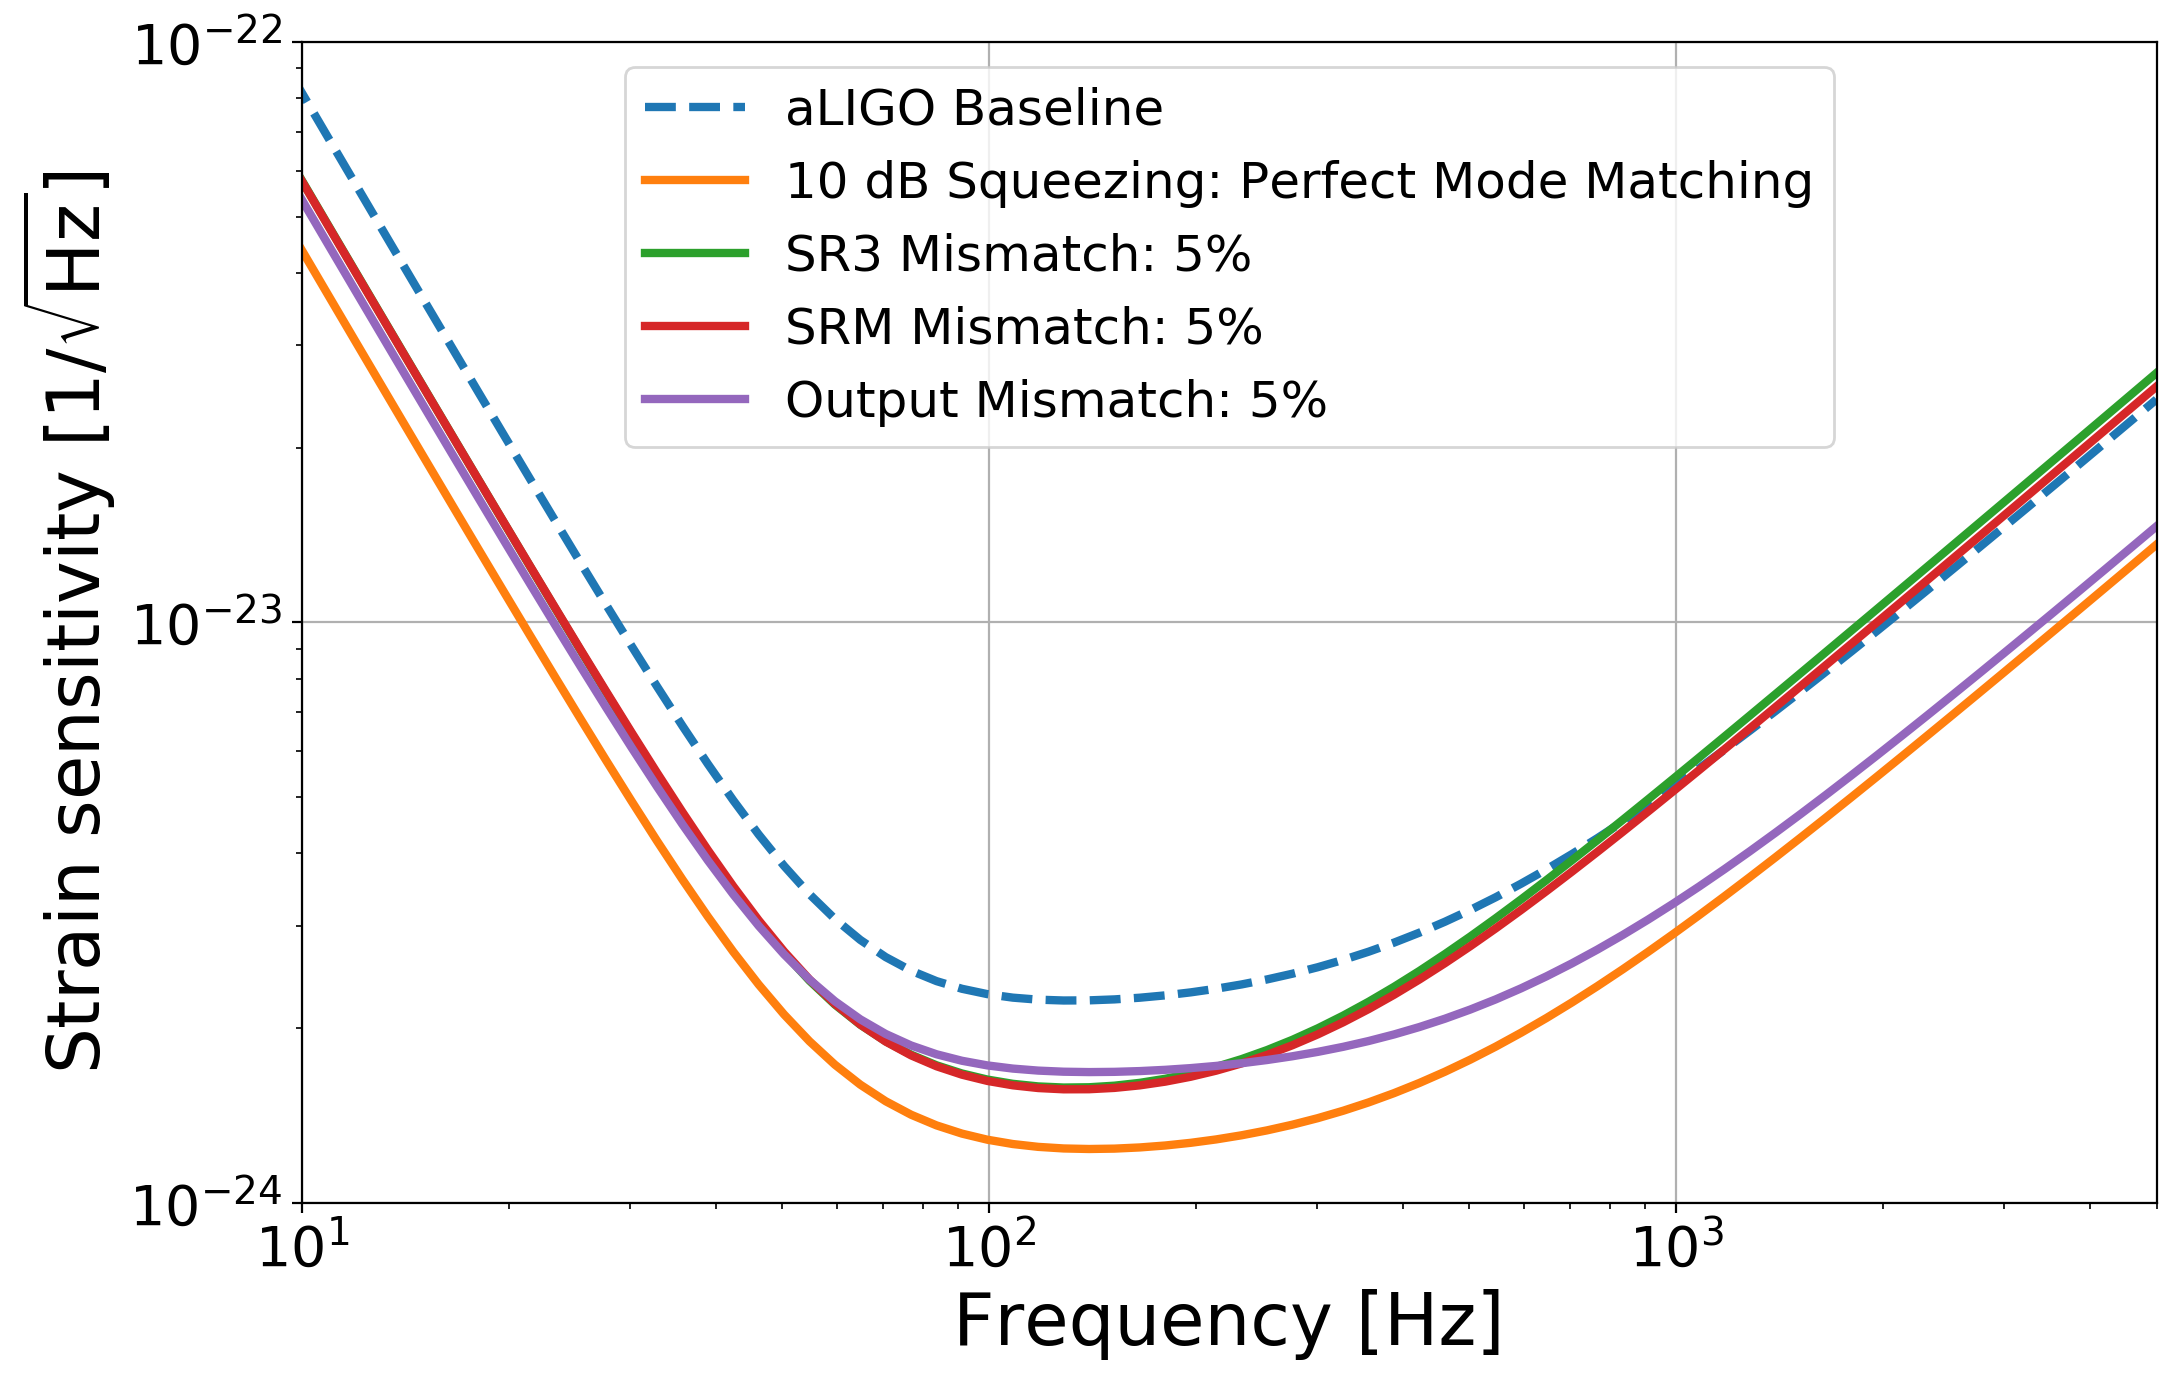

In [321]:
pl.figure(figsize=(11, 7), dpi=200)

pl.subplot(111)
pl.loglog(freq[0], np.real(darm['Perfect Mode Matching No Squeezing']),'--',linewidth=3, 
          label='aLIGO Baseline')
pl.loglog(freq[0], np.real(darm['Perfect Mode Matching']),linewidth=3, label='10 dB Squeezing: Perfect Mode Matching')
pl.loglog(freq[0], np.real(darm['SR3 Mismatch']),linewidth=3, label='SR3 Mismatch: 5%')
pl.loglog(freq[0], np.real(darm['SRM Mismatch']),linewidth=3, label='SRM Mismatch: 5%')
pl.loglog(freq[0], np.real(darm['Output Mismatch']),linewidth=3, label='Output Mismatch: 5%')

pl.xlim(10,5000)
pl.ylim(1e-24,1e-22)

pl.xlabel("Frequency [Hz]",fontsize=26)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=26)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=18)

pl.tight_layout()
pl.savefig('../../Figures/QM_sens_compare_mismatches.png')